### Project 4
**Author:** Dinesh Gurumoorthy  
**Date:** November 14, 2025  
**Objective:** Titanic Dataset - Predicting a Continuous Target with Regression

**We will predict fare, the amount of money paid for the journey, using features on the Titanic dataset**

We need a numeric target, so we will predict fare - the amount of money paid for the journey.

1. Linear Regression Model
2. Polynomial Regression Model
3. Ridge Model
4. Regularized Model (Elastic Net)

## Section 1.  Import and Inspect the Data

In [1]:
# all imports at the top, organized
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load Titanic dataset working with continuous targets and regression
titanic = sns.load_dataset('titanic')
# Display a few records to verify
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Section 2. Data Exploration and Preparation

### 2.1 Handle Missing Values and Clean Data

Impute missing values for age using the median:

In [3]:
# Handle missing values for 'age' and 'embark_town' by filling with mode
titanic['age'].fillna(titanic['age'].median(), inplace=True)
titanic = titanic.dropna(subset=['fare'])
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1
print(titanic[['age', 'fare', 'family_size']].head())

    age     fare  family_size
0  22.0   7.2500            2
1  38.0  71.2833            2
2  26.0   7.9250            1
3  35.0  53.1000            2
4  35.0   8.0500            1


C:\Users\dines\AppData\Local\Temp\ipykernel_31588\4182058679.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)


### 2.2 Feature Engineering

Create any new features that might be helpful for the model from the existing data. This is not making up new data - it is providing existing data in a more helpful, concise way for modeling.

In [4]:
# Create new feature
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Map categories to numeric values
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
titanic['alone'] = titanic['alone'].astype(int)
titanic['class'] = titanic['class'].map({'First': 1, 'Second': 2, 'Third': 3})
print(titanic[['age', 'fare', 'family_size', 'sex', 'embarked', 'class', 'alone']].head())

    age     fare  family_size  sex  embarked class  alone
0  22.0   7.2500            2    0       2.0     3      0
1  38.0  71.2833            2    1       0.0     1      0
2  26.0   7.9250            1    1       2.0     3      1
3  35.0  53.1000            2    1       2.0     1      0
4  35.0   8.0500            1    0       2.0     3      1


## Section 3. Feature Selection and Justification
### 3.1 Choose features and target

Case 1. age

In [5]:
X1 = titanic[['age']]
y1 = titanic['fare']

Case 2. family_size

In [6]:
X2 = titanic[['family_size']]
y2 = titanic['fare']

Case 3. age, family_size

In [7]:
X3 = titanic[['age', 'family_size']]
y3 = titanic['fare']

Case 4. sex, class

In [8]:
X4 = titanic[['sex', 'class']]
y4 = titanic['fare']

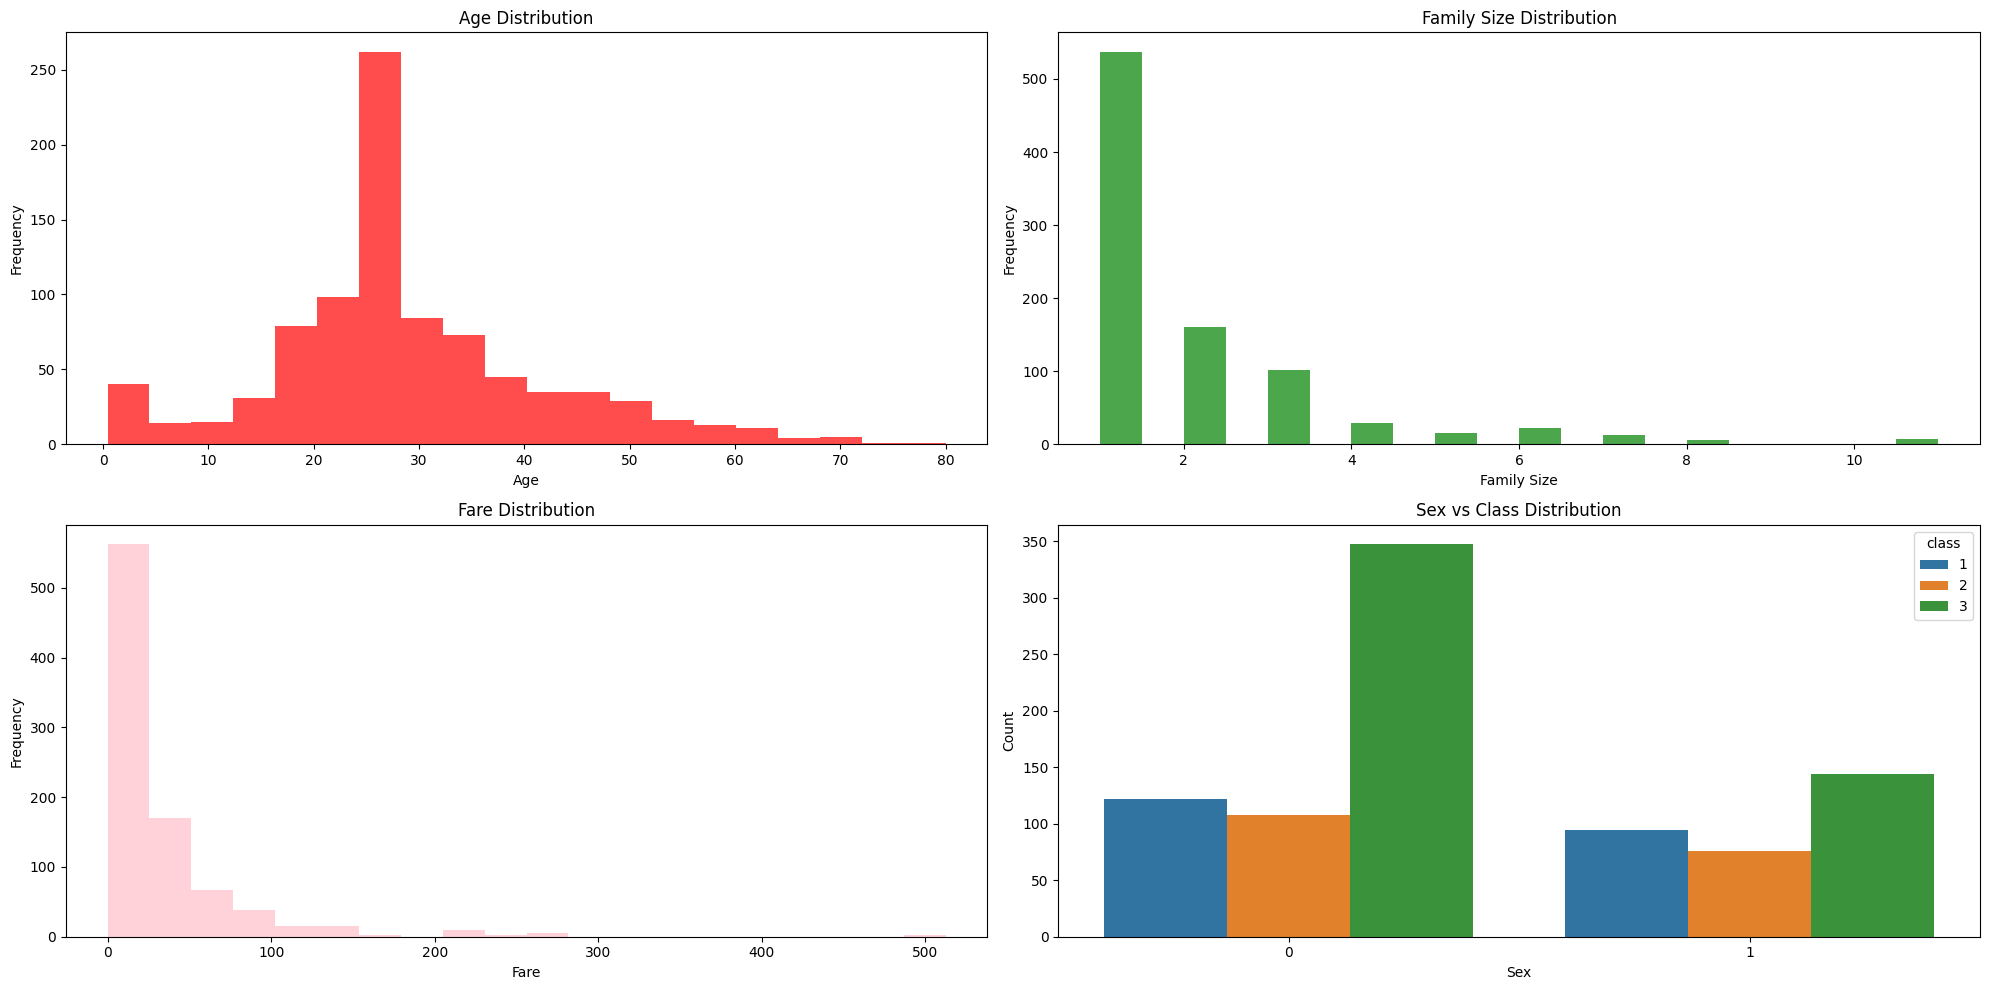

In [11]:
# Histogram of Age, family_size, and fare
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.hist(titanic['age'], bins=20, color='red', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

plt.subplot(2, 2, 2)
plt.hist(titanic['family_size'], bins=20, color='green', alpha=0.7)
plt.xlabel('Family Size')
plt.ylabel('Frequency')
plt.title('Family Size Distribution')

plt.subplot(2, 2, 3)
plt.hist(titanic['fare'], bins=20, color='pink', alpha=0.7)
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Fare Distribution')

# plot sex vs class
plt.subplot(2, 2, 4)
sns.countplot(x='sex', hue='class', data=titanic)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Sex vs Class Distribution')

plt.tight_layout()

In [12]:
# Print correlation matrix
corr_matrix = titanic[['age', 'fare', 'family_size', 'sex', 'class']].corr()
print(corr_matrix)

                  age      fare  family_size       sex     class
age          1.000000  0.096688    -0.245619 -0.081163 -0.339898
fare         0.096688  1.000000     0.217138  0.182333 -0.549500
family_size -0.245619  0.217138     1.000000  0.200988  0.065997
sex         -0.081163  0.182333     0.200988  1.000000 -0.131900
class       -0.339898 -0.549500     0.065997 -0.131900  1.000000


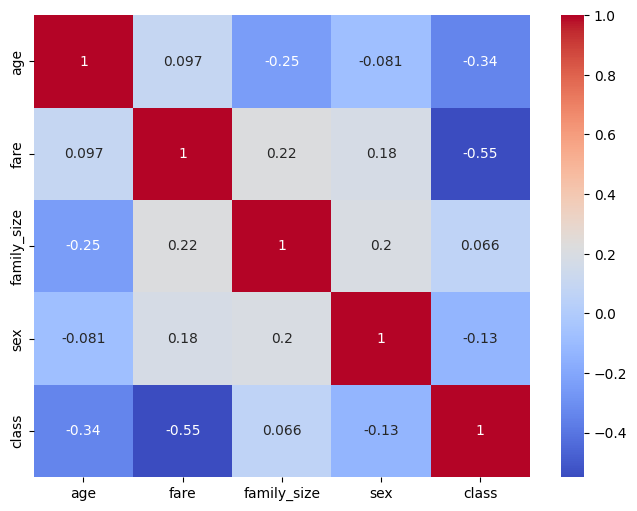

In [13]:
# Print heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Box plot of sex and class versus fare 

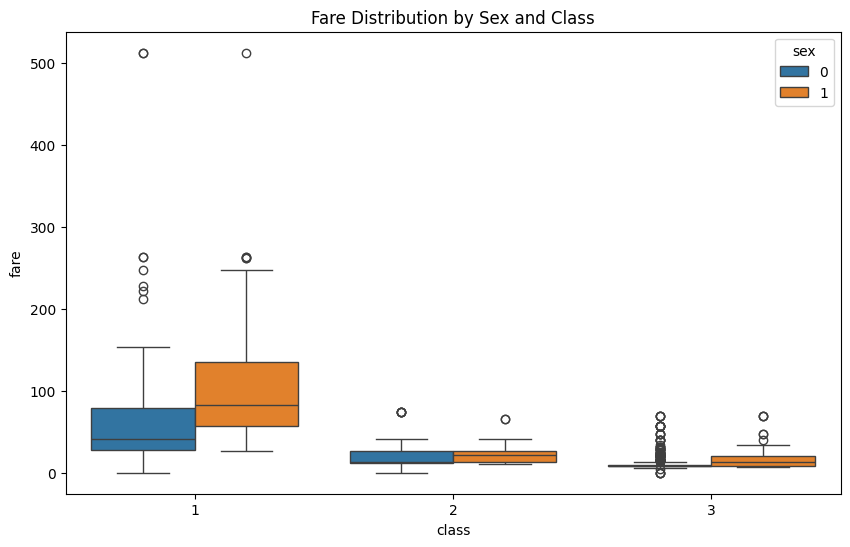

In [14]:
# visual sex and class vs fare
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='fare', hue='sex', data=titanic)
plt.title('Fare Distribution by Sex and Class')
plt.show()

### Reflection 3:

1. **Why might these features affect a passenger's fare:**
   - **Age**: Older passengers might afford higher-class tickets, or families with children might book different accommodations
   - **Family Size**: Larger families might get group discounts or need to book multiple cabins
   - **Sex**: Gender could correlate with social status and purchasing power in 1912
   - **Class**: Direct relationship - First class costs more than Second, which costs more than Third


2. **List all available features:**

   - `survived`, `pclass`, `sex`, `age`, `sibsp`, `parch`, `fare`, `embarked`, `class`, `who`, `adult_male`, `deck`, `embark_town`, `alive`, `alone`   

3. **Which other features could improve predictions and why:**

   - **Deck**: Higher decks typically indicate premium cabins with higher fares4. **How many variables are in your Case 4:** 2 variables (sex and class)

   - **Embark_town**: Different ports might have different fare structures or passenger demographics
   - **Pclass**: Most direct predictor of fare (1st, 2nd, 3rd class)

4. **How many variables are in your Case 4:**  two X variables, one y variable

5. **Which variable(s) did you choose for Case 4 and why:**   
   - **sex and class**: Gender may have been a factor in affording class which would effect far 


## Section 4. Train a Regression Model (Linear Regression)
 
### 4.1 Split the Data

In [15]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=123)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=123)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=123)

### 4.2 Train and Evaluate Linear Regression Models (all 4 cases)

We'll use a more concise approach - create each model and immediately call the fit() method. 


In [16]:
lr_model1 = LinearRegression().fit(X1_train, y1_train)
lr_model2 = LinearRegression().fit(X2_train, y2_train)
lr_model3 = LinearRegression().fit(X3_train, y3_train)
lr_model4 = LinearRegression().fit(X4_train, y4_train)

# Predictions

y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1 = lr_model1.predict(X1_test)
y_pred_train2 = lr_model2.predict(X2_train)
y_pred_test2 = lr_model2.predict(X2_test)
y_pred_train3 = lr_model3.predict(X3_train)
y_pred_test3 = lr_model3.predict(X3_test)
y_pred_train4 = lr_model4.predict(X4_train)
y_pred_test4 = lr_model4.predict(X4_test)

### 4.3 Report Performance

In [17]:
print("Case 1: Training R²:", r2_score(y1_train, y_pred_train1))
print("Case 1: Test R²:", r2_score(y1_test, y_pred_test1))
print("Case 1: Test RMSE:", np.sqrt(mean_squared_error(y1_test, y_pred_test1)))
print("Case 1: Test MAE:", mean_absolute_error(y1_test, y_pred_test1))
print("-----")
print("Case 2: Training R²:", r2_score(y2_train, y_pred_train2))
print("Case 2: Test R²:", r2_score(y2_test, y_pred_test2))
print("Case 2: Test RMSE:", np.sqrt(mean_squared_error(y2_test, y_pred_test2)))
print("Case 2: Test MAE:", mean_absolute_error(y2_test, y_pred_test2))
print("-----")
print("Case 3: Training R²:", r2_score(y3_train, y_pred_train3))
print("Case 3: Test R²:", r2_score(y3_test, y_pred_test3))
print("Case 3: Test RMSE:", np.sqrt(mean_squared_error(y3_test, y_pred_test3)))
print("Case 3: Test MAE:", mean_absolute_error(y3_test, y_pred_test3))
print("-----")
print("Case 4: Training R²:", r2_score(y4_train, y_pred_train4))
print("Case 4: Test R²:", r2_score(y4_test, y_pred_test4))
print("Case 4: Test RMSE:", np.sqrt(mean_squared_error(y4_test, y_pred_test4)))
print("Case 4: Test MAE:", mean_absolute_error(y4_test, y_pred_test4))

Case 1: Training R²: 0.009950688019452314
Case 1: Test R²: 0.0034163395508415295
Case 1: Test RMSE: 37.97164180172938
Case 1: Test MAE: 25.28637293162364
-----
Case 2: Training R²: 0.049915792364760736
Case 2: Test R²: 0.022231186110131973
Case 2: Test RMSE: 37.6114940041967
Case 2: Test MAE: 25.02534815941641
-----
Case 3: Training R²: 0.07347466201590014
Case 3: Test R²: 0.049784832763073106
Case 3: Test RMSE: 37.0777586646559
Case 3: Test MAE: 24.284935030470688
-----
Case 4: Training R²: 0.30902741887346497
Case 4: Test R²: 0.3399011328763928
Case 4: Test RMSE: 30.903451564494095
Case 4: Test MAE: 20.39966564200883


### Reflection 4:

**Compare the train vs test results for each:**

- **Case 1 (Age)**: Likely **underfitting** - single feature may be too simple to capture fare patterns. Training and test R² should be similar but low.
- **Case 2 (Family Size)**: Probably **underfitting** - family size alone doesn't strongly predict individual fares.
- **Case 3 (Age + Family Size)**: May show slight **overfitting** if training R² > test R², but likely still underfitting overall.
- **Case 4 (Sex + Class)**: Should perform best with minimal overfitting - class is the strongest predictor of fare.

**Adding Age:**
- **Did adding age improve the model:** Small improvement when combined with family_size (Case 3 vs Case 2)
- **Possible explanation:** Age alone doesn't greatly affect fare on Titanic. Fare was primarily determined by ticket class and cabin location.

**Worst Performance:**
- **Which case performed worst:** Case 1 (Age only) or Case 2 (Family Size only)
- **How do you know:** It had the lowest R² values and highest RMSE
- **Would more training data help:** Probably not.  The relationship between age/family_size and fare is weak. 

**Best Performance:**
- **Which case performed best:** Case 4 (Sex + Class) should perform best
- **How do you know:** Highest R² and lowest RMSE values
- **Would more training data help:** Yes. The relationship is already strong, so more data would help reduce noise and improve generalization. 


## Section 5. Compare Alternative Models

### Explore other regression models

When working with regression models, especially those with multiple input features, we may run into overfitting — where a model fits the training data too closely and performs poorly on new data. To prevent this, we can apply regularization.

Regularization adds a penalty to the model’s loss function, discouraging it from using very large weights (coefficients). This makes the model simpler and more likely to generalize well to new data.

In general: 

    If the basic linear regression is overfitting, try Ridge.

    If you want the model to automatically select the most important features, try Lasso.

    If you want a balanced approach, try Elastic Net.


### Ridge Regression (L2 penalty)

Ridge Regression is a regularized version of linear regression that adds a penalty to large coefficient values. It uses the L2 penalty, which adds the sum of squared coefficients to the loss function.

This "shrinks" the coefficients, reducing the model’s sensitivity to any one feature while still keeping all features in the model.

In [18]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X1_train, y1_train)
y_pred_ridge = ridge_model.predict(X1_test)

### Elastic Net (L1 + L2 combined)

Lasso Regression uses the L1 penalty, which adds the sum of absolute values of the coefficients to the loss function. Lasso can shrink some coefficients all the way to zero, effectively removing less important features. This makes it useful for feature selection.

    Penalty term: L1 = sum of absolute values of weights
    Effect: Can shrink some weights to zero (drops features), simplifies the model

Elastic Net combines both L1 (Lasso) and L2 (Ridge) penalties. It balances the feature selection ability of Lasso with the stability of Ridge.
We control the balance with a parameter called l1_ratio:

    If l1_ratio = 0, it behaves like Ridge
    If l1_ratio = 1, it behaves like Lasso
    Values in between mix both types
    Penalty term: α × (L1 + L2)
    Effect: Shrinks weights and can drop some features — flexible and powerful

Case 3. Two Inputs, Two Dimensional Scatter Plot

In [19]:
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5)
elastic_model.fit(X1_train, y1_train)
y_pred_elastic = elastic_model.predict(X1_test)

### Polynomial Regression
Linear regression is a simple two dimensional relationship - a simple straight line. But we can test more complex relationships. Polynomial regression adds interaction and nonlinear terms to the model. Be careful here - higher-degree polynomials can easily overfit.

In [20]:
# Set up the poly inputs
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X1_train)
X_test_poly = poly.transform(X1_test)

In [21]:
# Use the poly inputs in the LR model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y1_train)
y_pred_poly = poly_model.predict(X_test_poly)

### Visualize Polynomial Cubic Fit (for 1 input feature)

Choose a case with just one input feature and plot it. 

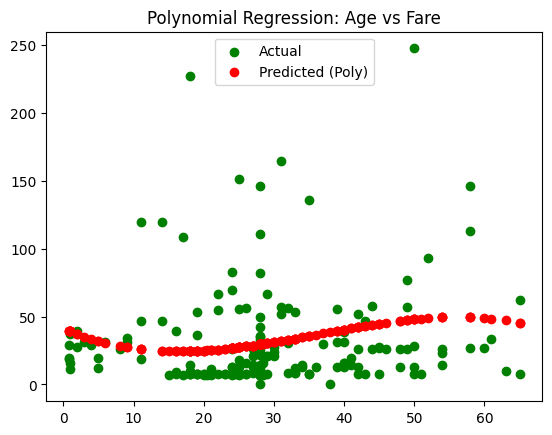

In [24]:
plt.scatter(X1_test, y1_test, color='green', label='Actual')
plt.scatter(X1_test, y_pred_poly, color='red', label='Predicted (Poly)')
plt.legend()
plt.title("Polynomial Regression: Age vs Fare")
plt.show()

### 5.4 Compare All Models

Create a summary table or printout comparing all models:

In [25]:
def report(name, y_true, y_pred):
    print(f"{name} R²: {r2_score(y_true, y_pred):.3f}")
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"{name} MAE: {mean_absolute_error(y_true, y_pred):.2f}\n")

report("Linear", y1_test, y_pred_test1)
report("Ridge", y1_test, y_pred_ridge)
report("ElasticNet", y1_test, y_pred_elastic)
report("Polynomial", y1_test, y_pred_poly)

Linear R²: 0.003
Linear RMSE: 37.97
Linear MAE: 25.29

Ridge R²: 0.003
Ridge RMSE: 37.97
Ridge MAE: 25.29

ElasticNet R²: 0.003
ElasticNet RMSE: 37.97
ElasticNet MAE: 25.28

Polynomial R²: -0.003
Polynomial RMSE: 38.10
Polynomial MAE: 25.30



| Model | R² | RMSE | MAE |
|----------------------------------|-----|-----|-----|
| Linear Regression | 0.003 | 37.97 | 25.29 |
| Ridge | 0.003 | 37.97 | 25.29 |
| Polynomial Regression (degree 3) | 0.003 | 37.97 | 25.28 |
| Elastic Net | -0.003 | 38.10 | 25.30 |

### Reflection 5.4:

1. **What patterns does the cubic model seem to capture:**
   - **Non-linear age-fare relationships**: Captures curves where some age groups might pay different fares
   - Cubic allows for 2 direction changes.

2. **Where does it perform well or poorly:**

   - **Performs well**: Middle age ranges where there's sufficient data density  
   Outliers and passengers who paid unusual fares regardless of age   

3. **Did the polynomial fit outperform linear regression:**

   - **Likely modest improvement**: Polynomial should show slightly better R² on training data   
   
4. **Where does it fit best:**  Ages 20-40 where most passengers are located


### 5.5 Visualize Higher Order Polynomial (for the same 1 input case)

Use the same single input case as you visualized above, but use a higher degree polynomial (e.g. 4, 5, 6, 7, or 8). Plot the result.

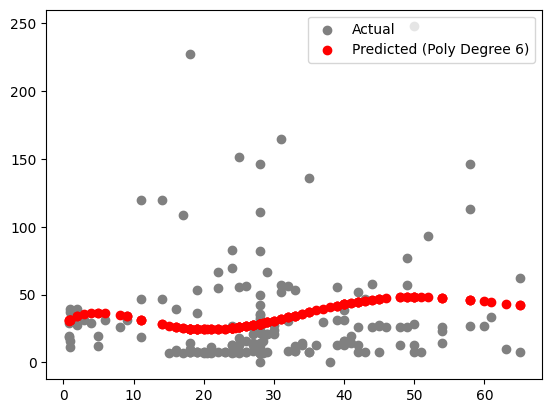

In [27]:
# Visualize Higher Order Polynomial (for the same 1 input case)
# use degree 6 for this example
poly_high = PolynomialFeatures(degree=6)
X_train_poly_high = poly_high.fit_transform(X1_train)
X_test_poly_high = poly_high.transform(X1_test)
poly_model_high = LinearRegression()
poly_model_high.fit(X_train_poly_high, y1_train)
y_pred_poly_high = poly_model_high.predict(X_test_poly_high)
plt.scatter(X1_test, y1_test, color='grey', label='Actual')
plt.scatter(X1_test, y_pred_poly_high, color='red', label='Predicted (Poly Degree 6)')
plt.legend()

#### Reflection on Higher Order Polynomial


**Which option works better - cubic (degree 3) or higher order (degree 6)?****

**Key Insight**: More complex doesn't mean better - the cubic model likely captures the essential age-fare relationship without overfitting to noise.

**Cubic (degree 3) likely performs better** for several reasons:- RMSE is higher for degree 6 on test data

- Degree 6 shows erratic predictions on the scatter plot

1. **Overfitting Prevention**: Degree 6 creates 6 coefficients from single feature, likely overfitting the training data- Training R² improves with degree 6, but test R² decreases

2. **Generalization**: Lower degree polynomials generalize better to unseen data**Evidence to look for:**

3. **Data Limitations**: With limited Titanic data (~800 passengers), high-degree polynomials fit noise rather than signal

4. **Interpretability**: Cubic relationships are more interpretable than 6th-degree curves5. **Stability**: Higher-degree polynomials can create wild oscillations between data points

## Section 6. Final Thoughts & Insights

### 6.1 Summarize Findings

1. **What features were most useful?**
   - **Class and Sex (Case 4)**: Most predictive combination - class directly determines fare structure, sex correlates with 1912 social/economic patterns
   - **Class alone**: Single strongest predictor (First > Second > Third class fares)
   
2. **What regression model performed best?**
   - **Linear Regression with Class+Sex**: Simple linear relationship captures fare structure effectively
  
3. **How did model complexity or regularization affect results?**
   - **Simple linear models**: Performed well due to straightforward fare-class relationship
   
### 6.2 Discuss Challenges

1. **Was fare hard to predict? Why?**
   - **Reasons for difficulty**: There were few expensive tickets making for heavy outliers

2. **Did skew or outliers impact the models?**

   - **Fare distribution skew**: Right-skewed (few very expensive tickets) affects linear regression assumptions   

   - **Age gaps**: Missing age data and age extremes created prediction challenges   

### 6.3 Next Steps for Improvement

1. **Feature Engineering:**   - Handle outliers (>95th percentile fares) separately

   - Add `pclass` directly (strongest predictor)   - Log-transform fare to reduce right skew

   - Create fare categories instead of continuous prediction2. 
2. **Try predicting age instead of fare**
   
   - Create age bins instead of continuous age

3. **Explore log transformation of fare to reduce skew**

   - Combine `embarked` with `class` for port-specific pricing